# Pre-compute

In [6]:
import numpy as np
from numba import njit
from math import gcd
from tqdm import trange
import matplotlib.pyplot as plt

@njit(cache=True)
def are_collinear(p1, p2, p3):
    """
    Numba-accelerated check for collinearity of three points.
    Points are given as 2-element arrays [x, y].
    """
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    return (y1 - y2) * (x1 - x3) == (y1 - y3) * (x1 - x2)


def find_all_collinear_triples(n, show_progress=False):
    """
    Enumerate all unordered collinear triples in an n x n grid.
    Returns:
      - triples: numpy array of shape (T, 3, 2) with coordinates [[x1,y1],[x2,y2],[x3,y3]]
      - idx_map: dict mapping (x,y) -> index
      - triple_set: set of index-triplets for O(1) membership testing

    Note: Not JIT-compiled due to Python dict usage; numba acceleration here
    offers limited benefit.
    """
    pts = [(i, j) for i in range(n) for j in range(n)]
    M = len(pts)
    idx_map = {pt: idx for idx, pt in enumerate(pts)}

    triples_idx = []
    iterator = trange(M, desc='Scanning base points') if show_progress else range(M)
    for p_idx in iterator:
        p = pts[p_idx]
        slopes = {}
        for q_idx in range(p_idx + 1, M):
            q = pts[q_idx]
            dx = q[0] - p[0]
            dy = q[1] - p[1]
            # Normalize direction vector
            if dx == 0:
                direction = (0, 1)
            elif dy == 0:
                direction = (1, 0)
            else:
                g = gcd(dx, dy)
                dxn, dyn = dx // g, dy // g
                if dxn < 0:
                    dxn, dyn = -dxn, -dyn
                direction = (dxn, dyn)
            slopes.setdefault(direction, []).append(q_idx)

        for q_list in slopes.values():
            L = len(q_list)
            if L >= 2:
                for i in range(L - 1):
                    for j in range(i + 1, L):
                        triples_idx.append((p_idx, q_list[i], q_list[j]))

    # Convert index triples to coordinate array
    T = len(triples_idx)
    triples = np.zeros((T, 3, 2), dtype=np.int64)
    for i, (i1, i2, i3) in enumerate(triples_idx):
        triples[i, 0] = pts[i1]
        triples[i, 1] = pts[i2]
        triples[i, 2] = pts[i3]

    # Build a set of sorted index-triplets for fast membership tests
    triple_set = set(triples_idx)
    return triples, idx_map, triple_set


def query_triple(idx_map, triple_set, p1, p2, p3, n):
    """
    Query whether points p1,p2,p3 are:
      - 'yes' if they are a known collinear triple
      - 'no'  if they lie within the grid but are not collinear
      - 'not found' if any point falls outside the n x n grid
    """
    pts = [p1, p2, p3]
    # Check bounds
    for p in pts:
        x, y = p
        if not (0 <= x < n and 0 <= y < n):
            return 'not found'
    # Map to indices and sort
    try:
        idxs = sorted(idx_map[(p[0], p[1])] for p in pts)
    except KeyError:
        return 'not found'
    triple_key = tuple(idxs)
    if triple_key in triple_set:
        return 'yes'
    # Check collinearity fallback
    if are_collinear(np.array(p1), np.array(p2), np.array(p3)):
        return 'no'
    return 'no'


def plot_grid_and_query(p1, p2, p3, n, result):
    """
    Plot the n x n grid, highlight the three query points, and draw the line if collinear.
    """
    plt.figure(figsize=(max(6, n/10), max(6, n/10)))
    # Plot all grid points
    xs, ys = np.meshgrid(np.arange(n), np.arange(n))
    plt.scatter(xs.flatten(), ys.flatten(), s=10, alpha=0.3)
    # Highlight query points
    pa, pb, pc = p1, p2, p3
    plt.scatter([pa[0], pb[0], pc[0]], [pa[1], pb[1], pc[1]], s=50, c='red')
    if result == 'yes':
        # draw line through first two points
        if pa[0] == pb[0]:
            plt.axvline(pa[0], color='blue')
        else:
            m = (pb[1] - pa[1]) / (pb[0] - pa[0])
            b = pa[1] - m * pa[0]
            x_line = np.linspace(0, n-1, 200)
            y_line = m * x_line + b
            plt.plot(x_line, y_line, color='blue')
        plt.title('Collinear: Yes')
    elif result == 'no':
        plt.title('Collinear: No')
    else:
        plt.title('Points Out of Range')
    plt.xlim(-1, n)
    plt.ylim(-1, n)
    plt.gca().set_aspect('equal', 'box')
    plt.show()

In [ ]:
n = 100
# Find all triples with progress bar
triples, idx_map, triple_set = find_all_collinear_triples(n, show_progress=True)
print(f'Found {triples.shape[0]} collinear triples in a {n}x{n} grid.')

# Example query and plot
p1, p2, p3 = (0, 0), (25, 25), (49, 49)
res = query_triple(idx_map, triple_set, p1, p2, p3, n)
print(f'Query result: {res}')
plot_grid_and_query(p1, p2, p3, n, res)

Scanning base points:   0%|          | 0/10000 [00:00<?, ?it/s]

Scanning base points: 100%|██████████| 10000/10000 [09:55<00:00, 16.78it/s]


Query result: not found


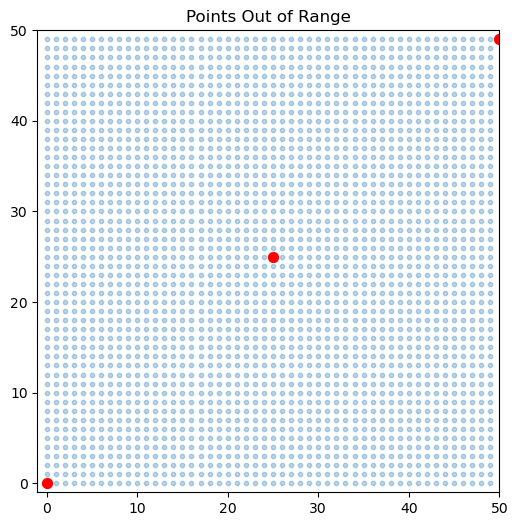

In [9]:
# Example query and plot
p1, p2, p3 = (0, 0), (25, 25), (50, 49)
res = query_triple(idx_map, triple_set, p1, p2, p3, n)
print(f'Query result: {res}')
plot_grid_and_query(p1, p2, p3, n, res)